In [1]:
import numpy as np
import cv2 as cv
import os
import glob
import matplotlib.pyplot as plt
from numpy.random import uniform
import pdb

test_images_path = "../data/validare/Validare"

def find_color_values_using_trackbar(frame):

    frame_hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
 
    def nothing(x):
        pass

    cv.namedWindow("Trackbar") 
    cv.createTrackbar("LH", "Trackbar", 0, 255, nothing)
    cv.createTrackbar("LS", "Trackbar", 0, 255, nothing)
    cv.createTrackbar("LV", "Trackbar", 0, 255, nothing)
    cv.createTrackbar("UH", "Trackbar", 255, 255, nothing)
    cv.createTrackbar("US", "Trackbar", 255, 255, nothing)
    cv.createTrackbar("UV", "Trackbar", 255, 255, nothing)
    
    
    while True:

        l_h = cv.getTrackbarPos("LH", "Trackbar")
        l_s = cv.getTrackbarPos("LS", "Trackbar")
        l_v = cv.getTrackbarPos("LV", "Trackbar")
        u_h = cv.getTrackbarPos("UH", "Trackbar")
        u_s = cv.getTrackbarPos("US", "Trackbar")
        u_v = cv.getTrackbarPos("UV", "Trackbar")


        l = np.array([l_h, l_s, l_v])
        u = np.array([u_h, u_s, u_v])
        mask_table_hsv = cv.inRange(frame_hsv, l, u)        

        res = cv.bitwise_and(frame, frame, mask=mask_table_hsv)    
        cv.imshow("Frame", frame)
        cv.imshow("Mask", mask_table_hsv)
        cv.imshow("Res", res)

        if cv.waitKey(25) & 0xFF == ord('q'):
                break
    cv.destroyAllWindows()
    
img = cv.imread(test_images_path + "/0007.jpg")
find_color_values_using_trackbar(img)
low_yellow = (0, 0, 173)
high_yellow = (217, 90, 255)
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
mask_yellow_hsv = cv.inRange(img_hsv, low_yellow, high_yellow)
cv.imshow('img_initial', img)
cv.imshow('mask_yellow_hsv', mask_yellow_hsv)
cv.waitKey(0)
cv.destroyAllWindows()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2581: error: (-27:Null pointer) NULL window: 'Trackbar' in function 'cvGetTrackbarPos'


In [1]:
#various imports
from Parameters import *
from FacialDetector import *
import pdb
from Visualize import *

In [2]:
#utility functions

def show_image(title,image):
    image=cv.resize(image,(0,0),fx=0.3,fy=0.3)
    cv.imshow(title,image)
    cv.waitKey(0)
    cv.destroyAllWindows()   

def non_maximal_suppression(image_detections,image_scores,image_size):
    x_out_of_bounds = np.where(image_detections[:, 2] > image_size[1])[0]
    y_out_of_bounds = np.where(image_detections[:, 3] > image_size[0])[0]
    print(x_out_of_bounds, y_out_of_bounds)
    image_detections[x_out_of_bounds, 2] = image_size[1]
    image_detections[y_out_of_bounds, 3] = image_size[0]
    sorted_indices = np.flipud(np.argsort(image_scores))
    sorted_image_detections = image_detections[sorted_indices]
    sorted_scores = image_scores[sorted_indices]

    is_maximal = np.ones(len(image_detections)).astype(bool)
    iou_threshold = 0.01


    for i in range(len(sorted_image_detections) - 1):
        if is_maximal[i] == True:  # don't change to 'is True' because is a numpy True and is not a python True :)
            for j in range(i + 1, len(sorted_image_detections)):
                if is_maximal[j] == True:  # don't change to 'is True' because is a numpy True and is not a python True :)
                    if facial_detector.intersection_over_union(sorted_image_detections[i],sorted_image_detections[j]) > iou_threshold:is_maximal[j] = False
                    else:  # verificam daca centrul detectiei este in mijlocul detectiei cu scor mai mare
                        c_x = (sorted_image_detections[j][0] + sorted_image_detections[j][2]) / 2
                        c_y = (sorted_image_detections[j][1] + sorted_image_detections[j][3]) / 2
                        if sorted_image_detections[i][0] <= c_x <= sorted_image_detections[i][2] and \
                                sorted_image_detections[i][1] <= c_y <= sorted_image_detections[i][3]:
                            is_maximal[j] = False
    return sorted_image_detections[is_maximal], sorted_scores[is_maximal]

def get_positive_features():
    positive_descriptors = []
    for f in os.listdir(positive_examples_path):
        if f[:-3] != "txt":
            files = os.listdir(positive_examples_path+"/"+f)

            for train_image in files:
                img_path = positive_examples_path + "/" + f + "/" + train_image
                img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
                
                img = cv.resize(img,(int(resize_param[1]), int(resize_param[0])))
                
                features = hog(
                    img, 
                    pixels_per_cell=pixels_cell,
                    cells_per_block=cells_block, 
                    feature_vector=True,
                    orientations=orientations,
                    block_norm="L2"
                )

                positive_descriptors.append(features)

                features = hog(
                    np.fliplr(img), 
                    pixels_per_cell=pixels_cell,
                    cells_per_block=cells_block,
                    feature_vector=True,
                    orientations=orientations,
                    block_norm="L2"
                )

                positive_descriptors.append(features)

    positive_features = np.array(positive_descriptors,dtype=object)
    return positive_features

def get_negative_features():
    num_negative_per_image = 5
    negative_descriptors = []

    for directory in directories:
        annotationFile = train_folder + directory + "_annotations.txt"

        with open(annotationFile) as f:
            inputRow = f.readline()
            while inputRow != '':
                splitData = inputRow.split()
                imgIndex = splitData[0]
                img_path = train_folder+directory+"/"+imgIndex

                facebox = [int(i) for i in splitData[1:5]]
                x1,y1,x2,y2 = [int(i) for i in splitData[1:5]] 

                img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

                num_rows = img.shape[0]
                num_cols = img.shape[1]
                
                x = np.random.randint(low=0, high=num_cols - resize_param[1], size=num_negative_per_image)
                y = np.random.randint(low=0, high=num_rows - resize_param[0], size=num_negative_per_image) 

                key = annotationFile + imgIndex

                for idx in range(len(y)):
                    patch = img[y[idx]: int(y[idx] + dim_window*resize_factors[0]), x[idx]: int(x[idx] + dim_window*resize_factors[1])]
                    patchbox = [x[idx],y[idx],int(x[idx] +dim_window*resize_factors[1]),int(y[idx] + dim_window*resize_factors[0])]
                    
                    to_add = True
                    for facebox in savedFaces[key]:
                        res = facial_detector.intersection_over_union(patchbox,facebox)
                        if res > 0.05:
                            to_add = False
    
                    if to_add:
                        descr = hog(
                            patch, 
                            pixels_per_cell=pixels_cell,
                            cells_per_block=cells_block, 
                            feature_vector=True,
                            orientations=orientations,
                            block_norm="L2"
                        )
                        negative_descriptors.append(descr)

                    else:
                        idx-=1


                if(len(negative_descriptors) >= number_negative_examples):
                    break

                inputRow = f.readline()

        if(len(negative_descriptors) >= number_negative_examples):
            break

    negative_features = np.array(negative_descriptors,dtype=object)
    return negative_features


detections = None  # array cu toate detectiile pe care le obtinem
scores = np.array([])  # array cu toate scorurile pe care le obtinem
file_names = np.array([])  # array cu fisiele, in aceasta lista fisierele vor aparea de mai multe ori, pentru fiecare

#predict with our classifier
def predict_examples(detections,scores,file_names):
    test_files = os.listdir(test_images_path)
    w = model.coef_.T
    bias = model.intercept_[0]
    num_test_images = len(test_files)
    descriptors_to_return = []

    img = cv.imread(train_folder+"/andy/0001.jpg",cv.IMREAD_GRAYSCALE)
    img = cv.resize(img,resize_param)

    feature = hog(
        img, 
        pixels_per_cell=pixels_cell,
        cells_per_block=cells_block, 
        feature_vector=False,
        orientations=orientations
    )
    print(feature.shape)
    
    
    for i, test_image in enumerate(test_files):
        print(i)
        test_img = cv.imread(test_images_path + "/" + test_image, cv.IMREAD_GRAYSCALE)
        
        image_scores = []
        image_detections = []
            
        low_pink = (0, 0, 173)
        high_pink = (217, 110, 255)

        pink_hsv = cv.imread(test_images_path + "/" + test_image)
        pink_hsv = cv.cvtColor(pink_hsv,cv.COLOR_BGR2HSV)
        mask_pink = cv.inRange(pink_hsv,low_pink,high_pink)
        
        for factor in [0.25,0.33,0.5,0.75,1,1.25,1.5,2]:
            img = cv.resize(test_img,(0,0),fx=factor,fy=factor)
            
            hog_descriptors = hog(
                img, 
                pixels_per_cell=pixels_cell,
                cells_per_block=cells_block, 
                feature_vector=False,
                orientations=orientations
            )

            num_cols = img.shape[1] // dim_hog_cell - 1
            num_rows = img.shape[0] // dim_hog_cell - 1
            f1 = resize_param[0] // dim_hog_cell - (cells_block[0]-1)
            f2 = resize_param[1] // dim_hog_cell - (cells_block[1]-1)

            for y in range(0, num_rows - f1):
                for x in range(0, num_cols - f2):
                    if hog_descriptors[y:y + f1, x:x + f2].flatten().shape != feature.flatten().shape:
                        continue
                        
                    x_min = int(x * dim_hog_cell*(1//factor))
                    y_min = int(y * dim_hog_cell*(1//factor))
                    x_max = int((x * dim_hog_cell + resize_param[1])*1//factor)
                    y_max = int((y * dim_hog_cell + resize_param[0])*1//factor)
                    
                    if mask_pink[y_min:y_max,x_min:x_max].mean() < 70:
                        continue
                        
                    descr = hog_descriptors[y:y + f1, x:x + f2].flatten()
                    score = np.dot(descr, w)[0] + bias
                    
                    if score > threshold and x_min>10 and y_min>10:
                        image_detections.append([x_min, y_min, x_max, y_max])
                        image_scores.append(score)


        if len(image_scores) > 0:
            image_detections, image_scores = non_maximal_suppression(np.array(image_detections),
                                                                          np.array(image_scores), img.shape)
        if len(image_scores) > 0:
            if detections is None:
                detections = image_detections
            else:
                detections = np.concatenate((detections, image_detections))
            scores = np.append(scores, image_scores)
            short_name = ntpath.basename(test_files[i])
            image_names = [short_name for ww in range(len(image_scores))]
            file_names = np.append(file_names, image_names)
                
    return detections,scores,file_names

def get_examples():
    images_for_negative_examples = []

    # Get examples
    directories = ["andy","louie","ora","tommy"]

    train_folder = "../data/antrenare/"
    positiveExamplesDir = "../data/exemplePozitive/"
    negativeExamplesDir = "../data/exempleNegative/"

    savedFaces = {}

    for directory in directories:
        annotationFile = train_folder + directory + "_annotations.txt"
        with open(annotationFile) as f:
            inputRow = f.readline()

            while inputRow != '':
                splitData = inputRow.split()
                imgIndex = splitData[0]

                imgPath = train_folder+directory+"/"+imgIndex
                img = cv.imread(imgPath)
                x1,y1,x2,y2 = [int(i) for i in splitData[1:5]] 
                positiveExample = img[y1:y2,x1:x2]

                saveImgPath = positiveExamplesDir+directory
                if not os.path.exists(saveImgPath):
                    os.makedirs(saveImgPath)  

                #save positive examples
                imgToSave = positiveExamplesDir+directory+"/"+splitData[5]+"".join(splitData[1:4])+imgIndex
                cv.imwrite(imgToSave,positiveExample)

                key = annotationFile + imgIndex
                if key not in savedFaces:
                    savedFaces[key] = [[x1,y1,x2,y2]]
                else:
                    savedFaces[key].append([x1,y1,x2,y2])

                #save as negative example
                images_for_negative_examples.append(imgPath)

                inputRow = f.readline()
    return savedFaces

In [3]:
#setup cell
params: Parameters = Parameters()
facial_detector: FacialDetector = FacialDetector(params)
    
base_dir = "../data"
positive_examples_path = base_dir + "/exemplePozitive"
negative_examples_path = base_dir + "/exempleNegative"
test_images_path = base_dir + "/validare/Validare"

# Get examples
directories = ["andy","louie","ora","tommy"]

train_folder = "../data/antrenare/"
positiveExamplesDir = "../data/exemplePozitive/"
negativeExamplesDir = "../data/exempleNegative/"

detections = None
scores = np.array([])
file_names = np.array([])

rectup_detections = None
rectup_scores = np.array([])
rectup_file_names = np.array([])

rectdown_detections = None
rectdown_scores = np.array([])
rectdown_file_names = np.array([])

# parameters

dim_hog_cell = 8
dim_window = 72
overlap = 0.3
number_positive_examples = 7236
number_negative_examples = 30000
has_annotations = False
threshold = 0
cells_block = (3,3)
orientations=22
pixels_cell = (dim_hog_cell,dim_hog_cell)
resize_factors = [1,1]
resize_param = (int(dim_window*resize_factors[0]),int(dim_window*resize_factors[1]))
iterate_factors = [[1,0.8],[0.9,1]]

for elem in iterate_factors:
    
    resize_factors = elem
    resize_param = (int(dim_window*resize_factors[0]),int(dim_window*resize_factors[1]))
    
    savedFaces = get_examples()    
    
    positive_features = get_positive_features()
    print(positive_features.shape)
    negative_features = get_negative_features()
    print(negative_features.shape)
    
    training_examples = np.concatenate((np.squeeze(positive_features), np.squeeze(negative_features)), axis=0)
    train_labels = np.concatenate((np.ones(positive_features.shape[0]), np.zeros(negative_features.shape[0])))
    # model = train_classifier(training_examples, train_labels)

    model = LinearSVC(
        C=10,
        max_iter=100000,
        random_state=0,
        dual = True,
        verbose=1
    )

    model.fit(training_examples, train_labels)
    acc = model.score(training_examples, train_labels)
    print(acc)
    
    detections = None  # array cu toate detectiile pe care le obtinem
    scores = np.array([])  # array cu toate scorurile pe care le obtinem
    file_names = np.array([])  # array cu fisiele, in aceasta lista fisierele vor aparea de mai multe ori, pentru fiecare

    if resize_factors[1] == 1:
        rectdown_detections,rectdown_scores,rectdown_file_names = predict_examples(detections,scores,file_names)
    else:
        rectup_detections,rectup_scores,rectup_file_names = predict_examples(detections,scores,file_names)
    
    del positive_features
    del negative_features
    del model

        
detections = None
scores = np.array([])
file_names = np.array([])

test_images_path = "../data/validare/Validare/"

for test_file in os.listdir(test_images_path):
    imgpath = test_images_path+"/"+test_file
    image = cv.imread(imgpath)
    short_file_name = ntpath.basename(test_file)
    
    indices_detections_current_image_up = np.where(rectup_file_names == short_file_name)
    indices_detections_current_image_down = np.where(rectdown_file_names == short_file_name)
    
    saved_rectup_detections = rectup_detections[indices_detections_current_image_up]
    saved_rectup_scores = rectup_scores[indices_detections_current_image_up]

    saved_rectdown_detections = rectdown_detections[indices_detections_current_image_down]
    saved_rectdown_scores = rectdown_scores[indices_detections_current_image_down]
    
    current_detections = np.concatenate((saved_rectup_detections,saved_rectdown_detections))
    current_scores = np.concatenate((saved_rectup_scores,saved_rectdown_scores))
    
    current_detections, current_scores = non_maximal_suppression(current_detections,current_scores,image.shape)

    
    if detections is None:
        detections = current_detections
    else:
        detections = np.concatenate((detections, current_detections))
    
    scores = np.append(scores,current_scores)
    
    short_name = ntpath.basename(test_file)
    image_names = [short_name for ww in range(len(current_scores))]
    file_names = np.append(file_names, image_names)

# facial_detector.eval_detections(detections, scores, file_names) 

(14472, 6930)
(25722, 6930)
[LibLinear]1.0
(5, 7, 3, 3, 22)
0
[] []
1
[] []
2
[] []
3
[] []
4
[] []
5
[] []
6
[] []
7
[] []
8
[] []
9
[] []
10
[] []
11
[] []
12
[] []
13
[] []
14
[] []
15
[] []
16
[] []
17
[] []
18
[] []
19
[] []
20
[] []
21
[] []
22
[] []
23
[] []
24
[] []
25
[] []
26
[] []
27
[] []
28
[] []
29
[] []
30
[] []
31
32
[] []
33
[] []
34
[] []
35
[] []
36
[] []
37
[] []
38
[] []
39
[] []
40
[] []
41
[] []
42
[] []
43
[] []
44
[] []
45
[] []
46
[] []
47
[] []
48
[] []
49
[] []
50
[] []
51
[] []
52
[] []
53
[] []
54
[] []
55
[] []
56
[] []
57
[] []
58
[] []
59
[] []
60
[] []
61
[] []
62
[] []
63
[] []
64
[] []
65
[] []
66
[] []
67
[] []
68
[] []
69
[] []
70
[] []
71
[] []
72
[] []
73
[] []
74
[] []
75
[] []
76
[] []
77
[] []
78
[] []
79
[] []
80
[] []
81
[] []
82
[] []
83
[] []
84
[] []
85
[] []
86
[] []
87
[] []
88
[] []
89
[] []
90
[] []
91
[] []
92
[] []
93
[] []
94
[] []
95
[] []
96
[] []
97
[] []
98
[] []
99
[] []
100
[] []
101
[] []
102
[] []
103
[] []
104
[] []
105
[]

In [24]:
# ground_truth_bboxes = np.loadtxt(params.path_annotations, dtype='str')
test_images_path = "../data/validare/Validare/"

for test_file in os.listdir(test_images_path):
    imgpath = test_images_path+"/"+test_file
    image = cv.imread(imgpath)
    short_file_name = ntpath.basename(test_file)
    indices_detections_current_image = np.where(file_names == short_file_name)
    current_detections = detections[indices_detections_current_image]
    current_scores = scores[indices_detections_current_image]

    for idx, detection in enumerate(current_detections):

        cv.rectangle(image, (detection[0], detection[1]), (detection[2], detection[3]), (0, 0, 255), thickness=1)
        cv.putText(image, 'score:' + str(current_scores[idx])[:4], (detection[0], detection[1]),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    annotations = ground_truth_bboxes[ground_truth_bboxes[:, 0] == short_file_name]

    # show ground truth bboxes
    for detection in annotations:
        cv.rectangle(image, (int(detection[1]), int(detection[2])), (int(detection[3]), int(detection[4])), (0, 255, 0), thickness=1)

    cv.imwrite(os.path.join(params.dir_save_files, "detections_" + short_file_name), image)
    print('Apasa orice tasta pentru a continua...')
    cv.imshow('image', np.uint8(image))
    cv.waitKey(0)

Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru 

KeyboardInterrupt: 

In [5]:
# np.save("./detections",detections)
# np.save("./scores",scores)
# np.save("./file_names",file_names)

In [6]:
classifier = LinearSVC(C = 10, max_iter=100000)


dim_hog_cell = 12
dim_window = 144
overlap = 0.3
number_positive_examples = 7236
number_negative_examples = 20000
has_annotations = False
threshold = 0
cells_block = (4,4)
orientations=20

pixels_cell = (dim_hog_cell,dim_hog_cell)

train_features = []
train_labels = []
for directory in directories:
    annotationFile = train_folder + directory + "_annotations.txt"
    with open(annotationFile) as f:
        inputRow = f.readline()

        while inputRow != '':
            splitData = inputRow.split()
            imgIndex = splitData[0]

            imgPath = train_folder+directory+"/"+imgIndex
            img = cv.imread(imgPath,cv.IMREAD_GRAYSCALE)
            x1,y1,x2,y2 = [int(i) for i in splitData[1:5]] 
            positive_example = img[y1:y2,x1:x2]

            positive_example = cv.resize(positive_example,(dim_window,dim_window))

            hog_descriptors = hog(
                positive_example, 
                pixels_per_cell=pixels_cell,
                cells_per_block=cells_block, 
                feature_vector=True,
                orientations=orientations
            )

            
            if splitData[-1] != "unknown":
                train_features.append(hog_descriptors)
                train_labels.append(splitData[-1])


            inputRow = f.readline()

classifier.fit(train_features,train_labels)




LinearSVC(C=10, max_iter=100000)

In [7]:
interest_faces = ["andy", "louie", "ora", "tommy"]
dict_detections = {}
dict_scores = {}
dict_file_names = {}
predictions = []
for test_file in os.listdir(test_images_path):
    imgpath = test_images_path+"/"+test_file
    image = cv.imread(imgpath,cv.IMREAD_GRAYSCALE)
    short_file_name = ntpath.basename(test_file)
    indices_detections_current_image = np.where(file_names == short_file_name)
    current_detections = detections[indices_detections_current_image]
    current_scores = scores[indices_detections_current_image]
    

    for idx, detection in enumerate(current_detections):
        if current_scores[idx] < 0:
            continue

        x1,y1,x2,y2 = detection
        face = image[y1:y2,x1:x2]
        face = cv.resize(face,(dim_window,dim_window))
        hog_descriptors = hog(
            face, 
            pixels_per_cell=pixels_cell,
            cells_per_block=cells_block, 
            feature_vector=True,
            orientations=orientations
        )
        
        prediction = classifier.predict(hog_descriptors.reshape(1,-1))


        if prediction[0] not in dict_detections:
            dict_detections[prediction[0]] = [detection]
            dict_scores[prediction[0]] = [current_scores[idx]]
            dict_file_names[prediction[0]] = [short_file_name]
        else:
            dict_detections[prediction[0]].append(detection)
            dict_scores[prediction[0]].append(current_scores[idx])
            dict_file_names[prediction[0]].append(short_file_name)
            
        predictions.append([prediction[0],x1,x2,y1,y2])


In [19]:
task1_path = "./task1/"

if not os.path.exists(task1_path):
    os.mkdir(task1_path)

np.save(task1_path+"detections",detections)
np.save(task1_path+"scores",scores)
np.save(task1_path+"file_names",file_names)

In [20]:
interest_faces = ["andy", "louie", "ora", "tommy"]
task2_path = "./task2/"
if not os.path.exists(task2_path):
    os.mkdir(task2_path)

for key in interest_faces:
    np.save(task2_path+"detections_"+key,np.array(dict_detections[key]))
    np.save(task2_path+"scores_"+key,np.array(dict_scores[key]))
    np.save(task2_path+"file_names_"+key,np.array(dict_file_names[key]))

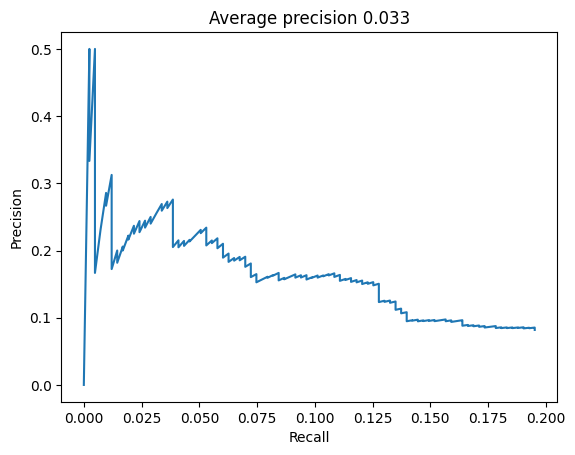

0.03325926453464124

In [22]:
facial_detector.eval_detections(detections,scores,file_names)

In [21]:
detections = np.load("./task1/detections.npy")
scores = np.load("./task1/scores.npy")
file_names = np.load("./task1/file_names.npy")